235


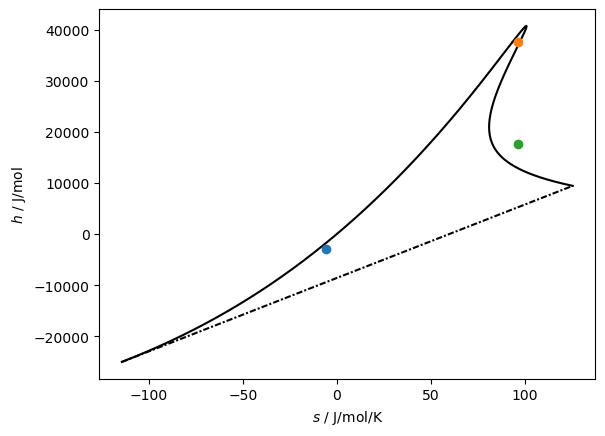

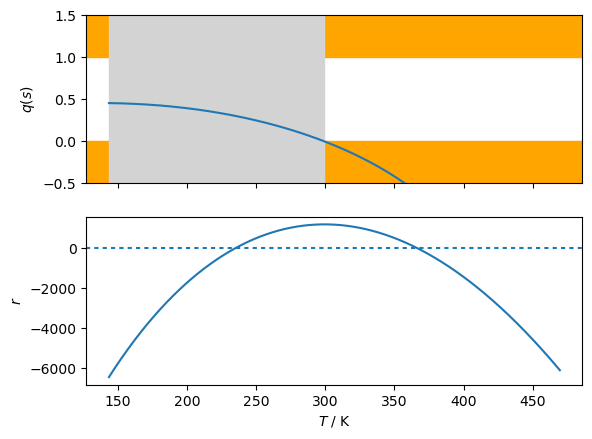

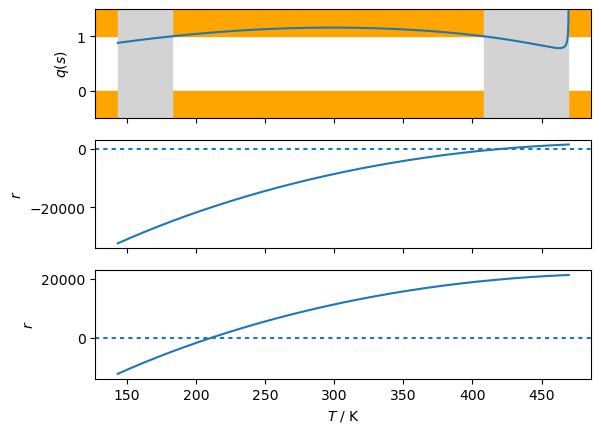

In [21]:
import json 
import functools

import numpy as np
import matplotlib.pyplot as plt

import teqpflsh 
import CoolProp.CoolProp as CP

FLD = 'PENTANE'
j = json.load(open(f'superancillaryJSON/{FLD}_exps.json'))
sa = teqpflsh.SuperAncillary(json.dumps(j))

AS = CP.AbstractState('HEOS',FLD)
def calc(T, rho, AS, key):
    AS.specify_phase(CP.iphase_gas)
    AS.update(CP.DmolarT_INPUTS, rho, T)
    val = AS.keyed_output(key)
    AS.unspecify_phase()
    return val

# Order of ms per variable, likely MUCH faster in C++
sa.add_variable(k='S', caller=functools.partial(calc, AS=AS, key=CP.iSmolar))
sa.add_variable(k='H', caller=functools.partial(calc, AS=AS, key=CP.iHmolar))

figmain, axmain = plt.subplots(1)
def plot_sat(q):
    approx1dh = sa.get_approx1d(k='H', q=q)
    approx1ds = sa.get_approx1d(k='S', q=q)

    Ts = np.linspace(approx1dh.xmin, approx1dh.xmax, 10000)
    S = np.zeros_like(Ts)
    sa.eval_sat_many(k='S', T=Ts, q=q, y=S)
    H = np.zeros_like(Ts)
    sa.eval_sat_many(k='H', T=Ts, q=q, y=H)

    plt.plot(S, H, color='k')
    return S[0], H[0]

approx1dh = sa.get_approx1d(k='H', q=0)
s0, h0 = plot_sat(q=0)
s1, h1 = plot_sat(q=1)
plt.plot([s0,s1], [h0,h1], dashes=[3,1,1,1], color='k')
    
axmain.set(xlabel='$s$ / J/mol/K', ylabel='$h$ / J/mol')
 
Tpt = 235; q = 0.3
hptA = sa.get_yval(k='H', T=Tpt, q=q)
sptA = sa.get_yval(k='S', T=Tpt, q=q)

hptB = hptA-0
sptB = sptA

Tpt = 0.9*Tc; q = 0.95
hptC = sa.get_yval(k='H', T=Tpt, q=q)
sptC = sa.get_yval(k='S', T=Tpt, q=q)

hptD = hptC-20000
sptD = sptC

def overlay_points(points, ofname):

    fig, axes = plt.subplots(1+len(points), 1, sharex=True)

    Ts = np.geomspace(approx1dh.xmin, 0.9*approx1dh.xmax, 1000).tolist() + np.geomspace(0.9*approx1dh.xmax, approx1dh.xmax*0.999999, 100000).tolist()

    for ipt, (hpt, spt) in enumerate(points):

        axmain.plot(spt, hpt, 'o')

        r, Qcalc = [], []
        for T in Ts:
            qq = sa.get_vaporquality(T=T, k='S', propval=spt)
            qh = sa.get_vaporquality(T=T, k='H', propval=hpt)
            r.append(sa.get_yval(T=T, q=qq, k='H')-hpt)
#             r.append(qq-qh)
            Qcalc.append(qq)

        solns = sa.solve_for_T(propval=spt, k='S', q=True, bits=64, max_iter=100, boundsftol=1e-13) + sa.solve_for_T(propval=spt, k='S', q=False, bits=64, max_iter=100, boundsftol=1e-13)
        if len(solns) == 3:
            bands = [(approx1dh.xmin, solns[0][0]),(solns[1][0], solns[2][0])]
        elif len(solns) == 1:
            bands = [(approx1dh.xmin, solns[0][0])]
        elif len(solns) == 2:
            bands = [(solns[0][0], solns[1][0])]
        else:
            raise ValueError(len(solns))

        if ipt == 0:
            ax1 = axes[0]
            ax1.plot(Ts, np.array(Qcalc))
            ax1.set_ylim(-0.5,1.5)
            ax1.set(ylabel=r'$q(s)$')
            ax1.axhspan(1,1.5, color='orange', zorder=-1)
            ax1.axhspan(-0.5, 0, color='orange', zorder=-1)
            for band in bands:
                ax1.axvspan(*band, color='lightgrey')

        axx = axes[ipt+1]
        axx.plot(Ts, r)
        axx.axhline(0, dashes=[2, 2])
        axx.set_ylabel('$r$')
        if ipt == len(points)-1:
            axx.set_xlabel('$T$ / K')
    fig.savefig(ofname)

points = [(hptA, sptA), (hptB, sptB), (hptC, sptC), (hptD, sptD)]
overlay_points(points[1:2], ofname='liquid_side.pdf')
overlay_points(points[2::], ofname='vapor_side.pdf')
figmain.savefig(f'{FLD}_HS_main.pdf')